In [106]:
import os
import math
from functools import partial

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

### Glorot and He Initialization

$$ \mathrm{Normal\ distribution\ with\ mean\ 0\ and\ variance\ } \sigma^{2} = \frac{1}{fan_{\mathrm{avg}}} $$

$$ \mathrm{Or\ a\ uniform\ distribution\ between\ } -r\ \mathrm{and\ } +r\ \mathrm{,\ with\ } r = \sqrt{\frac{3}{fan_{\mathrm{avg}}}}$$

In [3]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

In [5]:
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

### Nonsaturating Activation Functions

$$ \mathrm{ELU}_{\alpha}(z) = $$

In [7]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[8]),
    keras.layers.Dense(10, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2)
])

In [10]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[8]),
    keras.layers.Dense(10, kernel_initializer='he_normal'),
    keras.layers.PReLU()
])

In [12]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[8]),
    keras.layers.Dense(10, kernel_initializer='lecun_normal', activation='selu')
])

### Batch Normalization

$$ 1.\ \mathbf{\mu}_{B} = \frac{1}{m_{B}}\sum_{i = 1}^{m_{B}} \mathbf{x}^{(i)}$$

$$ 2.\ \mathbf{\sigma}_{B}^{2} = \frac{1}{m_{B}}\sum_{i = 1}^{m_{B}} (\mathbf{x}^{(i)} - \mathbf{\mu}_{B})^{2}$$

$$ 3.\ \widehat{\mathbf{x}}^{(i)} = \frac{\mathbf{x}^{(i)} - \mathbf{\mu}_{B}}{\sqrt{\mathbf{\sigma}_{B}^{2} + \epsilon}}$$

$$ 4.\ \mathbf{z}^{(i)} = \mathbf{\gamma} \otimes \widehat{\mathbf{x}}^{(i)} + \mathbf{\beta}$$

### Implementing Batch Normalization with Keras

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [15]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [17]:
model.layers[1].updates

/usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


[]

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(10, activation='softmax')
])

$$ \widehat{\mathbf{v}} \leftarrow  \widehat{\mathbf{v}}  \times \mathrm{momentum} + \mathbf{v} \times (1 - \mathrm{momentum}) $$

### Gradient Clipping

In [20]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

### Transfer Learning with Keras

In [22]:
model_A = keras.models.load_model('my_mnist_model.h5')
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

In [23]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [24]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [25]:
model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [27]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [34]:
y_train_full_B = (y_train_full == 1).astype(int)
y_test_B = (y_test == 1).astype(int)

In [35]:
history = model_B_on_A.fit(X_train_full, y_train_full_B, epochs=16, validation_data=(X_test, y_test_B))

Epoch 1/16
1875/1875 [==============================] - 4s 2ms/step - loss: 8.4818 - accuracy: 0.9921 - val_loss: 3.1329 - val_accuracy: 0.9975
Epoch 2/16
1875/1875 [==============================] - 3s 2ms/step - loss: 1.8224 - accuracy: 0.9981 - val_loss: 3.2045 - val_accuracy: 0.9974
Epoch 3/16
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5032 - accuracy: 0.9978 - val_loss: 2.8456 - val_accuracy: 0.9970
Epoch 4/16
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5206 - accuracy: 0.9975 - val_loss: 2.7176 - val_accuracy: 0.9976
Epoch 5/16
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4392 - accuracy: 0.9979 - val_loss: 3.6010 - val_accuracy: 0.9965
Epoch 6/16
1875/1875 [==============================] - 4s 2ms/step - loss: 1.7307 - accuracy: 0.9975 - val_loss: 3.3078 - val_accuracy: 0.9977
Epoch 7/16
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2588 - accuracy: 0.9983 - val_loss: 3.4449 - val_accuracy:

In [37]:
model_B_on_A.evaluate(X_test, y_test_B)

313/313 [==============================] - 0s 1ms/step - loss: 2.8295 - accuracy: 0.9976


[2.8294708728790283, 0.9976000189781189]

### Momentum Optimisation

$$ \mathbf{m} \leftarrow \beta\ \mathbf{m} - \eta \nabla_{\theta} J({\mathbf{\theta}}) $$

$$ \theta \leftarrow \theta + \mathbf{m} $$

In [38]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

$$ \mathbf{m} \leftarrow \beta\ \mathbf{m} - \eta \nabla_{\theta} J({\mathbf{\theta}} + \beta\ \mathbf{m}) $$

$$ \theta \leftarrow \theta + \mathbf{m} $$

In [39]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

$$ \mathbf{s} \leftarrow \mathbf{s} + \nabla_{\theta} J({\mathbf{\theta}}) \otimes \nabla_{\theta} J({\mathbf{\theta}} )  $$

$$ \theta \leftarrow \theta - \eta \nabla_{\theta} J({\mathbf{\theta}}) \oslash \sqrt{\mathbf{s} + \epsilon} $$

### RMSProp

$$ \mathbf{s} \leftarrow \beta\mathbf{s} + (1 - \beta)\nabla_{\theta} J({\mathbf{\theta}}) \otimes \nabla_{\theta} J({\mathbf{\theta}} )  $$

$$ \theta \leftarrow \theta - \eta \nabla_{\theta} J({\mathbf{\theta}}) \oslash \sqrt{\mathbf{s} + \epsilon} $$

In [40]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### Adam and Nadam Optimisation


$$ 1.\ \mathbf{m} \leftarrow \beta_{1}\ \mathbf{m} - (1 - \beta_{1})\eta \nabla_{\theta} J({\mathbf{\theta}}) $$


$$ 2.\ \mathbf{s} \leftarrow \beta_{2}\mathbf{s} + (1 - \beta_{2})\nabla_{\theta} J({\mathbf{\theta}}) \otimes \nabla_{\theta} J({\mathbf{\theta}} )  $$

$$ 3.\ \widehat{\mathbf{m}} \leftarrow \frac{\mathbf{m}}{1 - \beta_{1}^{\top}} $$

$$ 4.\ \widehat{\mathbf{s}} \leftarrow \frac{\mathbf{s}}{1 - \beta_{2}^{\top}} $$

$$ 5.\ \theta \leftarrow \theta + \eta \widehat{\mathbf{m}} \oslash \sqrt{\widehat{\mathbf{s}} + \epsilon} $$

In [41]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

### Learning Rate Scheduling

In [42]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [43]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [44]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

In [45]:
exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)

In [46]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model_A.fit(X_train_full, y_train_full, epochs=16, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/16
1875/1875 [==============================] - 5s 2ms/step - loss: 40547578280678329942016.0000 - accuracy: 0.0989 - val_loss: 2.3021 - val_accuracy: 0.0974
Epoch 2/16
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3016 - accuracy: 0.1103 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 3/16
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 4/16
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 5/16
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 6/16
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 7/16
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 

In [47]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

In [48]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model_A.fit(X_train_full, y_train_full, epochs=16, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/16
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 2/16
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 3/16
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 4/16
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 5/16
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 6/16
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 7/16
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy:

In [49]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [50]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [52]:
s = 20 * len(X_train_full) // 32 # number of steps in 20 epochs, batch size 32
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

### l<sub>1</sub> and l<sub>2</sub> Regularisation

In [53]:
layer = keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal', 
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [55]:
RegularizedDense = partial(keras.layers.Dense,
                           activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [56]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

### Dropout

In [57]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, kernel_initializer='he_normal', activation='elu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, kernel_initializer='he_normal', activation='elu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])

### Monte Carlo (MC) Dropout

In [59]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])

In [62]:
y_proba = y_probas.mean(axis=0)
y_proba

array([[1.99999996e-02, 5.39733889e-03, 6.10609436e-13, ...,
        0.00000000e+00, 1.43050998e-01, 7.33125627e-01],
       [0.00000000e+00, 1.08597618e-36, 0.00000000e+00, ...,
        0.00000000e+00, 3.11710924e-01, 4.59130138e-01],
       [3.55079334e-11, 2.98578236e-02, 2.55860943e-18, ...,
        0.00000000e+00, 1.33081317e-01, 4.02926832e-01],
       ...,
       [0.00000000e+00, 3.99184339e-02, 1.69609950e-06, ...,
        0.00000000e+00, 2.49999925e-01, 5.29253960e-01],
       [8.01325381e-24, 9.27661452e-03, 9.99999978e-03, ...,
        0.00000000e+00, 5.02125062e-02, 5.10198832e-01],
       [0.00000000e+00, 3.38901231e-40, 1.72581105e-03, ...,
        0.00000000e+00, 1.23382494e-01, 3.76955211e-01]], dtype=float32)

In [63]:
np.round(model.predict(X_test[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [64]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1

In [66]:
np.round(y_proba[:1], 2)

array([[0.02, 0.01, 0.  , 0.01, 0.01, 0.07, 0.01, 0.  , 0.14, 0.73]],
      dtype=float32)

In [67]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.14, 0.05, 0.  , 0.08, 0.1 , 0.26, 0.1 , 0.  , 0.35, 0.44]],
      dtype=float32)

In [69]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

### Max-Norm Regularization

In [71]:
keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal', 
                   kernel_constraint=keras.constraints.max_norm(1.))

### Exercises

#### 8.
##### a.

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

##### b.

In [73]:
model.add(keras.layers.Dense(10, activation="softmax"))

In [74]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [75]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 742s 4us/step


In [86]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [87]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 26s 15ms/step - loss: 9.2694 - accuracy: 0.1383 - val_loss: 2.1487 - val_accuracy: 0.2328
Epoch 2/100
1407/1407 [==============================] - 22s 15ms/step - loss: 2.0830 - accuracy: 0.2428 - val_loss: 2.0474 - val_accuracy: 0.2336
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.9477 - accuracy: 0.2926 - val_loss: 2.0591 - val_accuracy: 0.2596
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.8598 - accuracy: 0.3228 - val_loss: 1.8694 - val_accuracy: 0.3296
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.7980 - accuracy: 0.3458 - val_loss: 1.7851 - val_accuracy: 0.3404
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.7453 - accuracy: 0.3670 - val_loss: 1.7687 - val_accuracy: 0.3514
Epoch 7/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.7072 - accuracy: 0.3775 - val_loss: 1

1407/1407 [==============================] - 19s 13ms/step - loss: 1.1392 - accuracy: 0.5944 - val_loss: 1.5792 - val_accuracy: 0.4702
Epoch 57/100
1407/1407 [==============================] - 19s 14ms/step - loss: 1.1376 - accuracy: 0.5899 - val_loss: 1.5978 - val_accuracy: 0.4676


In [88]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.5242 - accuracy: 0.4650


[1.524153470993042, 0.4650000035762787]

##### c.

In [89]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 2 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 45s 22ms/step - loss: 1.9729 - accuracy: 0.2988 - val_loss: 1.6748 - val_accuracy: 0.3976
Epoch 2/100
1407/1407 [==============================] - 27s 20ms/step - loss: 1.6785 - accuracy: 0.4023 - val_loss: 1.5861 - val_accuracy: 0.4264
Epoch 3/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1.6066 - accuracy: 0.4304 - val_loss: 1.5326 - val_accuracy: 0.4436
Epoch 4/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5483 - accuracy: 0.4497 - val_loss: 1.5017 - val_accuracy: 0.4646
Epoch 5/100
1407/1407 [==============================] - 28s 20ms/step - loss: 1.5017 - accuracy: 0.4651 - val_loss: 1.4163 - val_accuracy: 0.4982
Epoch 6/100
1407/1407 [==============================] - 28s 20ms/step - loss: 1.4593 - accuracy: 0.4836 - val_loss: 1.4197 - val_accuracy: 0.4910
Epoch 7/100
1407/1407 [==============================] - 28s 20ms/step - loss: 1.4293 - accuracy: 0.4969 - val_loss: 1

[1.3268986940383911, 0.54339998960495]

##### d.

In [90]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 3 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 31s 16ms/step - loss: 2.0806 - accuracy: 0.2568 - val_loss: 1.8298 - val_accuracy: 0.3382
Epoch 2/100
1407/1407 [==============================] - 20s 15ms/step - loss: 1.7541 - accuracy: 0.3756 - val_loss: 1.8512 - val_accuracy: 0.3396
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.6417 - accuracy: 0.4211 - val_loss: 1.6536 - val_accuracy: 0.3922
Epoch 4/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5431 - accuracy: 0.4563 - val_loss: 1.6655 - val_accuracy: 0.4174
Epoch 5/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.4984 - accuracy: 0.4737 - val_loss: 1.5808 - val_accuracy: 0.4504
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.4417 - accuracy: 0.4917 - val_loss: 1.5568 - val_accuracy: 0.4516
Epoch 7/100
1407/1407 [==============================] - 19s 14ms/step - loss: 1.4010 - accuracy: 0.5108 - val_loss: 1

[1.4892140626907349, 0.49380001425743103]

##### e.

In [91]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 27s 16ms/step - loss: 2.0527 - accuracy: 0.2834 - val_loss: 1.7384 - val_accuracy: 0.3922
Epoch 2/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.6687 - accuracy: 0.4070 - val_loss: 1.7031 - val_accuracy: 0.4020
Epoch 3/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5785 - accuracy: 0.4453 - val_loss: 1.6444 - val_accuracy: 0.4192
Epoch 4/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.5039 - accuracy: 0.4691 - val_loss: 1.6284 - val_accuracy: 0.4458
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.4480 - accuracy: 0.4945 - val_loss: 1.6178 - val_accuracy: 0.4656
Epoch 6/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.4004 - accuracy: 0.5092 - val_loss: 1.5052 - val_accuracy: 0.4686
Epoch 7/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.3518 - accuracy: 0.5305 - val_loss: 1

[1.4890233278274536, 0.49380001425743103]

In [92]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [93]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [94]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [95]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4946

##### f.

In [96]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 4s 10ms/step - loss: nan - accuracy: 0.1364


(9.999999747378752e-06,
 9.615227699279785,
 2.6200389862060547,
 3.9805657523018976)

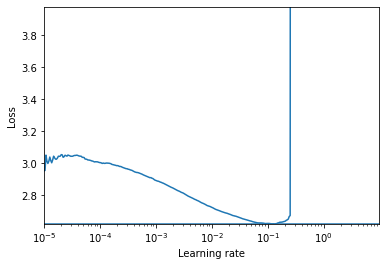

In [107]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = keras.backend.get_value(model.optimizer.lr)
    keras.backend.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    keras.backend.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [111]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        keras.backend.set_value(self.model.optimizer.lr, rate)

In [112]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 5s 15ms/step - loss: 2.0559 - accuracy: 0.2811 - val_loss: 1.8059 - val_accuracy: 0.3804
Epoch 2/15
352/352 [==============================] - 4s 11ms/step - loss: 1.7649 - accuracy: 0.3738 - val_loss: 1.6721 - val_accuracy: 0.4166
Epoch 3/15
352/352 [==============================] - 4s 11ms/step - loss: 1.6200 - accuracy: 0.4254 - val_loss: 1.6323 - val_accuracy: 0.4256
Epoch 4/15
352/352 [==============================] - 4s 11ms/step - loss: 1.5395 - accuracy: 0.4551 - val_loss: 1.5964 - val_accuracy: 0.4394
Epoch 5/15
352/352 [==============================] - 4s 11ms/step - loss: 1.4951 - accuracy: 0.4724 - val_loss: 1.5912 - val_accuracy: 0.4564
Epoch 6/15
352/352 [==============================] - 4s 11ms/step - loss: 1.4524 - accuracy: 0.4847 - val_loss: 1.5454 - val_accuracy: 0.4604
Epoch 7/15
352/352 [==============================] - 4s 11ms/step - loss: 1.4115 - accuracy: 0.4980 - val_loss: 1.6541 - val_accuracy: 0.4404